In [1]:
# plot distribution of rechits in a cluster, for paper draft

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
%%time
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()

fpath_bkg['signal'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_1.root'


    

NEvents = {}

for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree_bkg[k] = root_dir['ntuples']['llp']
    NEvents[k] = root_dir['ntuples']['NEvents'][1]
    a = tree_bkg[k]["gLLP_csc"].array()
    print(len(a))

signal /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_1.root
20000
CPU times: user 334 ms, sys: 14.5 ms, total: 348 ms
Wall time: 1.63 s


# Load variables

In [4]:
%%time

JET_PT_CUT = 10
MUON_PT_CUT = 20
clusterIndex = {}
cscRechitsX = {}
cscRechitsY = {}
cscRechitsZ = {}
cscRechitsR = {}
cscRechitClusterSize= {}
cscRechitsX_all= {}
cscRechitsY_all= {}
cscRechitClusterNStation = {}
cscRechitsStation = {}
cscRechitsStation_all ={}
cscRechitsPhi_all = {}
cscRechitsEta_all = {}
cscRechitsPhi = {}
cscRechitsEta = {}
eventNum = {}
lumiSec = {}
runNum = {}
cluster_index = ''

for k,T in tree_bkg.items():
    ########### SELECTION: CLUSTERS ############
    sel_rechits = T.array('cscRechitsClusterId') == 0


#     sel_rechitcluster = np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0
    
#     me1112_veto = 0
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
# #     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
# #     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
# #     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc'))


#     root [8] llp->Scan("cscRechitClusterSize:cscRechitsClusterId:cscRechitsX","cscRechitClusterSize>130")
    

    
#     clusterIndex[k] = np.where(np.any(sel_rechitcluster, axis=1))
    sel_rechitcluster = T.array('cscRechitClusterSize')>500
    
    sel_ev = sel_rechitcluster.sum()>0
# ########### SELECTION: EVENTS ############
    cscRechitsX[k] = T.array("cscRechitsX")[sel_rechits][sel_ev]
    cscRechitsY[k] = T.array("cscRechitsY")[sel_rechits][sel_ev]
    cscRechitsZ[k] = T.array("cscRechitsZ")[sel_rechits][sel_ev]
    cscRechitsR[k] = (cscRechitsX[k]**2+cscRechitsY[k]**2)**0.5
    cscRechitsStation[k] = T.array("cscRechitsStation")[sel_rechits][sel_ev]
    cscRechitsPhi[k] = T.array("cscRechitsPhi")[sel_rechits][sel_ev]
    cscRechitsEta[k] = T.array("cscRechitsEta")[sel_rechits][sel_ev]

    cscRechitsX_all[k] = T.array("cscRechitsX")[sel_ev]
    cscRechitsY_all[k] = T.array("cscRechitsY")[sel_ev]

    cscRechitsPhi_all[k] = T.array("cscRechitsPhi")[sel_ev]
    cscRechitsEta_all[k] = T.array("cscRechitsEta")[sel_ev]
    cscRechitClusterSize[k] = T.array("cscRechitClusterSize")[sel_ev][:,0]
    cscRechitClusterNStation[k] = T.array("cscRechitClusterNStation")[sel_ev][:,0]

    cscRechitsStation_all[k] = T.array("cscRechitsStation")[sel_ev]

    eventNum[k] = T.array("eventNum")[sel_ev]
    lumiSec[k] = T.array("lumiNum")[sel_ev]
    runNum[k] =  T.array("runNum")[sel_ev]


#     nCscSimhits[k] = T.array('nCscSimhits')[sel_ev]
#     nCscRechits[k] = T.array('ncscRechits')[sel_ev]
#     nCscWireDigis[k] = T.array('nCscWireDigis')[sel_ev]
#     nCscStripDigis[k] = T.array('nCscStripDigis')[sel_ev]
#     cscWireDigiChamber[k] = T.array('cscWireDigiChamber')[sel_ev]
#     cscStripDigiChamber[k] = T.array('cscStripDigiChamber')[sel_ev]
#     nCscWireDigis_maxChamber[k] = []
#     nCscWireDigis_maxChamber2[k] = []
#     nCscWireDigis_maxChamber3[k] = []
#     nCscWireDigis_maxChamber4[k] = []


#     nCscStripDigis_maxChamber[k] = []
#     for i,ev in enumerate(cscWireDigiChamber[k]):
# #         if len(ev) == 0: continue
# #         if not i == 0:continue
#         counts = list(np.bincount(ev[ev>0]))+list(np.bincount(-1*ev[ev<0]))
#         counts.sort(reverse=True)
#         nCscWireDigis_maxChamber[k].append(counts[0] if len(counts)>=1 else sum(counts))
#         nCscWireDigis_maxChamber2[k].append(sum(counts[:2]) if len(counts)>=2 else sum(counts))
#         nCscWireDigis_maxChamber3[k].append(sum(counts[:3]) if len(counts)>=3 else sum(counts))
#         nCscWireDigis_maxChamber4[k].append(sum(counts[:4]) if len(counts)>=4 else sum(counts))


# #         nCscWireDigis_maxChamber[k].append(counts[0]+counts[2])


#     nCscWireDigis_maxChamber[k] = np.array(nCscWireDigis_maxChamber[k])
#     nCscWireDigis_maxChamber2[k] = np.array(nCscWireDigis_maxChamber2[k])
#     nCscWireDigis_maxChamber3[k] = np.array(nCscWireDigis_maxChamber3[k])
#     nCscWireDigis_maxChamber4[k] = np.array(nCscWireDigis_maxChamber4[k])


#     print(len(nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k]),len(nCscSegCluster_JetMuonVetoCluster0p4_Me1112Veto[k]))

CPU times: user 996 ms, sys: 14.9 ms, total: 1.01 s
Wall time: 1.01 s


In [5]:
i = 43

print(eventNum[k][43],lumiSec[k][43],runNum[k][43])


45076 46 1


## x-y plot

537.0
526 526 2

here 0.23679999649524688


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/rechit_distribution/Nrechit526evtNum43.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/rechit_distribution/Nrechit526evtNum43.C has been generated
Info in <TCanvas::Print>: pdf file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/rechit_distribution/Nrechit526evtNum43.pdf has been created


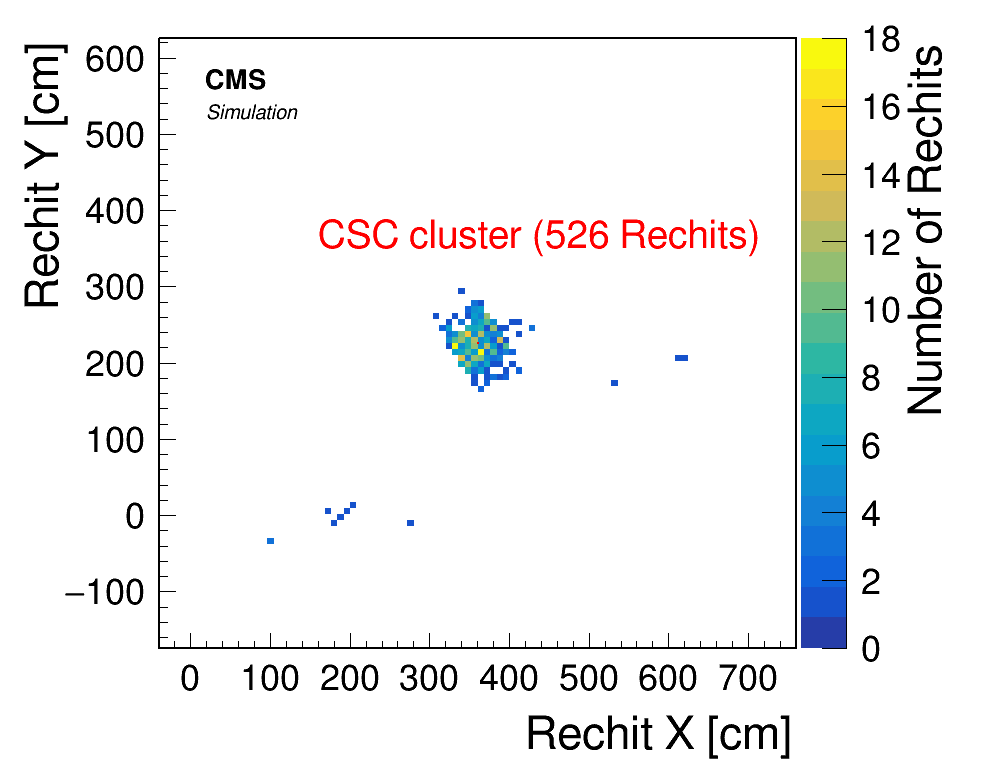

In [5]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])
# from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
# import CMS_lumi, tdrstyle



# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
leg = rt.TLegend(0.60,0.75,0.97,0.93)
# leg = rt.TLegend(0.75,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
k = 'signal'
etaphi = 0

for evtNum in range(len(cscRechitClusterSize['signal'])):
    if not evtNum==43:continue
#     x_mean = np.mean(np.abs(cscRechitsX[k][evtNum]))
#     y_mean = np.mean(np.abs(cscRechitsY[k][evtNum]))
#     x_mean = -1*np.mean(cscRechitsX[k][evtNum])
#     y_mean = np.mean(cscRechitsY[k][evtNum])
#     spread = 400
#     h[k] = create_TH2D( np.column_stack((-1*cscRechitsX_all[k][evtNum],cscRechitsY_all[k][evtNum])), axis_title=['Rechit X [cm]', 'Rechit Y [cm]', 'Number of Rechits'], \
#                        name=k, binning=[100,x_mean-spread,x_mean+spread,100,y_mean-spread,y_mean+spread])
    
    if etaphi:
        x_mean = np.mean(cscRechitsEta[k][evtNum])
        y_mean = np.mean(cscRechitsPhi[k][evtNum])
        x_spread = 1.5
        y_spread = 0.6
    #     h[k] = create_TH2D( np.column_stack((np.abs(cscRechitsX[k][evtNum]),np.abs(cscRechitsY[k][evtNum]))), axis_title=['X [cm]', 'Y [cm]', 'Events'], \
    #                        name=k, binning=[50,x_mean-spread,x_mean+spread,50,y_mean-spread,y_mean+spread])
        h[k] = create_TH2D( np.column_stack((cscRechitsEta_all[k][evtNum],cscRechitsPhi_all[k][evtNum])), axis_title=['Rechit #eta', 'Rechit #phi', 'Number of Rechits'], \
                           name=k, binning=[100,x_mean-x_spread/2,x_mean+x_spread,100,y_mean-y_spread/2,y_mean+y_spread])
    #     h[k] = create_TH2D( np.column_stack((cscRechitsEta[k][evtNum],cscRechitsPhi[k][evtNum])), axis_title=['Rechit #eta', 'Rechit #phi', 'Number of Rechits'], \
    #                        name=k, binning=[100,x_mean-x_spread,x_mean+x_spread,100,y_mean-y_spread,y_mean+y_spread])
    else:
        x_mean = np.mean(np.abs(cscRechitsX[k][evtNum]))
        y_mean = np.mean(np.abs(cscRechitsY[k][evtNum]))
        x_mean = -1*np.mean(cscRechitsX[k][evtNum])
        y_mean = np.mean(cscRechitsY[k][evtNum])
        spread = 400
        h[k] = create_TH2D( np.column_stack((-1*cscRechitsX_all[k][evtNum],cscRechitsY_all[k][evtNum])), axis_title=['Rechit X [cm]', 'Rechit Y [cm]', 'Number of Rechits'], \
                           name=k, binning=[100,x_mean-spread,x_mean+spread,100,y_mean-spread,y_mean+spread])
#         h[k] = create_TH2D( np.column_stack((-1*cscRechitsX[k][evtNum],cscRechitsY[k][evtNum])), axis_title=['Rechit X [cm]', 'Rechit Y [cm]', 'Number of Rechits'], \
#                            name=k, binning=[100,x_mean-spread,x_mean+spread,100,y_mean-spread,y_mean+spread])


    h[k].GetZaxis().SetTitleOffset(0.75)
    print(h[k].Integral())
    print(len(np.abs(cscRechitsX[k][evtNum])), cscRechitClusterSize['signal'][evtNum], cscRechitClusterNStation['signal'][evtNum])
    h[k].Draw('colz')
    
    ## draw ellipse
#     el1 = rt.TEllipse(x_mean, y_mean,x_spread/5,x_spread/4)
    el1 = rt.TEllipse(x_mean, y_mean,x_spread/5,y_spread/3.5)


    el1.SetFillColorAlpha(1001,0)
    el1.SetLineWidth(2)
    el1.SetLineColor(2)
    el1.Draw('same')
    
    latex = rt.TLatex()
    latex.SetTextSize(0.04)
    latex.SetTextSize(0.055)
    latex.SetTextFont(42)
    latex.SetTextColor(2)
#     latex.DrawLatex(x_mean-125,y_mean+125, "CSC cluster (526 Rechits)")
    if etaphi:latex.DrawLatex(x_mean-0.2,y_mean-0.25, "CSC cluster (526 Rechits)")
    else: latex.DrawLatex(x_mean-200,y_mean+125, "CSC cluster (526 Rechits)")

#     latex.DrawLatex(x_mean-125,y_mean+125, "N_{hits} = 526")



    c.SetRightMargin(0.2)
    
    CMS_lumi.cmsText     = "CMS"
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Simulation"
    CMS_lumi.iPos=11
    CMS_lumi.relPosX = 0.12
    CMS_lumi.relPosY = 0.05

    CMS_lumi.CMS_lumi(c, 0, 11)
    
    c.Draw()
    if etaphi:
        c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/rechit_distribution/Nrechit'+str(cscRechitClusterSize['signal'][evtNum])+'evtNum'+str(evtNum)+'_etaphi.png')
        c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/rechit_distribution/Nrechit'+str(cscRechitClusterSize['signal'][evtNum])+'evtNum'+str(evtNum)+'_etaphi.C')
        c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/rechit_distribution/Nrechit'+str(cscRechitClusterSize['signal'][evtNum])+'evtNum'+str(evtNum)+'_etaphi.pdf')


    else:
        c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/rechit_distribution/Nrechit'+str(cscRechitClusterSize['signal'][evtNum])+'evtNum'+str(evtNum)+'.png')
        c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/rechit_distribution/Nrechit'+str(cscRechitClusterSize['signal'][evtNum])+'evtNum'+str(evtNum)+'.C')
        c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/rechit_distribution/Nrechit'+str(cscRechitClusterSize['signal'][evtNum])+'evtNum'+str(evtNum)+'.pdf')

# r-z plot

1208 1208
0.0021080970764160156


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


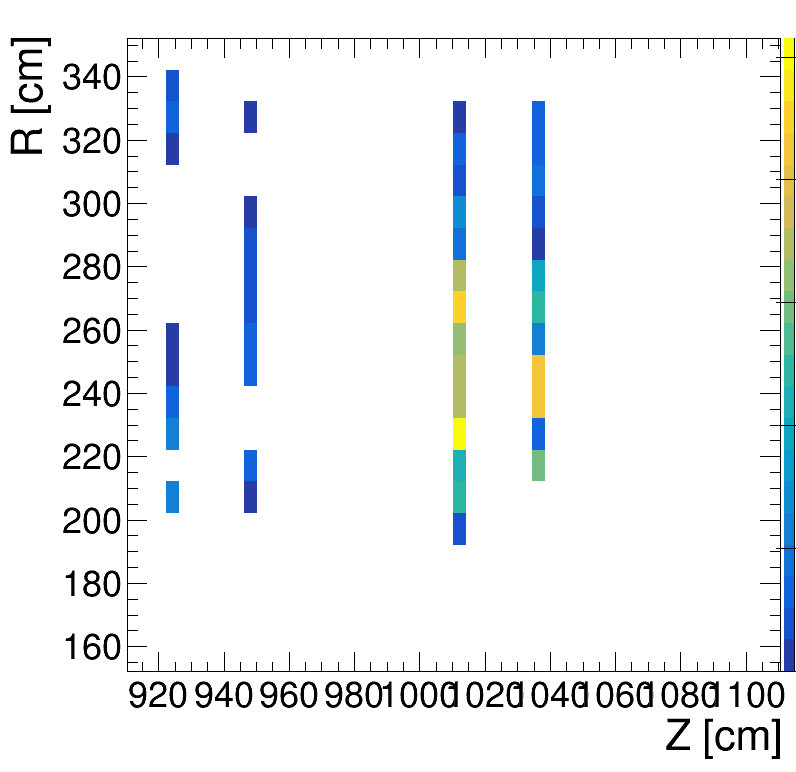

In [56]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.60,0.75,0.97,0.93)
# leg = rt.TLegend(0.75,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
k = 'signal'
evtNum = 3
x_mean = np.mean(np.abs(cscRechitsZ[k][evtNum]))
y_mean = np.mean(np.abs(cscRechitsR[k][evtNum]))
spread = 100
h[k] = create_TH2D( np.column_stack((np.abs(cscRechitsZ[k][evtNum]),np.abs(cscRechitsR[k][evtNum]))), axis_title=['Z [cm]', 'R [cm]', 'Events'], \
                   name=k, binning=[50,x_mean-spread,x_mean+spread,20,y_mean-spread,y_mean+spread])
print(len(np.abs(cscRechitsX[k][evtNum])), cscRechitClusterSize['signal'][evtNum])
h[k].Draw('colz')
c.Draw()
print(time.time()-start_t)